In [2]:
import fasttext
import os
import pandas as pd
import csv
import re

In [3]:
def update_labels(input_file, output_file):
    # Read the CSV file
    df = pd.read_csv(input_file)
    
    # Iterate through the Label column
    for i, label in enumerate(df['Label']):
        if label.lower() == 'description':
            df.at[i, 'Label'] = 'Label_1'
        else:
            df.at[i, 'Label'] = 'Label_2'
    
    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_file, index=False)
    return df  # Return the updated DataFrame

# Example usage
input_file = "CandogramData/job_sentences.csv"
output_file = "CandogramData/job_sentences_train.txt"
df= update_labels(input_file, output_file)

In [4]:
model = fasttext.train_supervised(input="CandogramData/job_sentences_train.txt", 
                                  epoch=1000, wordNgrams=5, lr=0.2, minCount=5)
# Save the model
model.save_model('CandogramData/job_sentences_data_model.bin')
df.head()

,Label,Sentences
0,Label_1,Minimum Qualifications:
1,Label_1,Education: Must meet one of the following: RN ...
2,Label_1,"Experience: Must be certified tech, RN or NP a..."
3,Label_1,Clinical experience as a surgical assistant pr...
4,Label_1,Licensure/Certification: Certified surgical as...


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df['Sentences']
y = df['Label']
train_texts, test_texts, train_labels, test_labels = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Handle potential NaN values
train_labels = train_labels.fillna('').astype(str)
train_texts = train_texts.fillna('').astype(str)

# Prepare training data
train_texts = ['__label__' + label + ' ' + text for label, text in zip(train_labels, train_texts)]
test_texts = ['__label__' + label + ' ' + text for label, text in zip(test_labels, test_texts)]

with open('CandogramData/train_fasttext.txt', 'w') as f_train:
    f_train.write('\n'.join(train_texts))

with open('CandogramData/test_fasttext.txt', 'w') as f_test:
    f_test.write('\n'.join(test_texts))

In [20]:
model = fasttext.train_supervised(
    input="CandogramData/train_fasttext.txt",
    epoch=300,  
    lr=0.3,    # Learning rate
    wordNgrams=2,  
    dim = 200
)

In [21]:
test_results = model.test("CandogramData/test_fasttext.txt")
accuracy = test_results[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 88.46%


In [8]:
current_directory = os.getcwd()

# Construct file path
file_name = ("CandogramData/CLEANED_Assistant.csv")
file_path = os.path.join(current_directory, file_name)

# Read CSV file into DataFrame
df_cleaned = pd.read_csv(file_path, header=0, low_memory=False)
print(df_cleaned)

      RequisitionID                                     JobDescription
0            284738  Job Summary:   \n\n Assist the surgeon during ...
1        R100051919  Current Employees: \n\n If you are a current S...
2         202200099  (PT) Food Pantry Assistant  \n\n  Print  (  \n...
3        2023-29253  Job Description\n\n Preschool Teacher Assistan...
4             R4619  ***HIRING EVENT*** ALL POSITIONS\n\nWHERE:Ted'...
...             ...                                                ...
18189       CLIMBER  Agency Children & Family Services, Office of \...
18190       CLIMBER  Agency Children & Family Services, Office of \...
18191      23-14684  Zoning Assistant  \n\n  Print  (  \n\n  Apply ...
18192           813  [DPR Summer/Seasonal] Program Assistant, Senio...
18193           758  {DPR Summer/Seasonal] Program Assistant - Care...

[18194 rows x 2 columns]


In [9]:
job_descriptions = pd.DataFrame(df_cleaned.iloc[1034:(len(df_cleaned))])
shape = job_descriptions.shape
print(shape)
job_descriptions.head()

(17160, 2)


,RequisitionID,JobDescription
1034,JP-003772148,Description:\n\nResponsible for the timely com...
1035,02880-0012214770,Description \n\nManufacturing company in the W...
1036,2023-1486,Are you a controller at a smaller company look...
1037,03500-0012637807,Description \n\nRobert Half has teamed up with...
1038,04160-0012602062,Description \n\nUtilize your detail-attentiven...


In [10]:
# Define a function to classify sentences
def classify_sentences(sentences):
    predictions = model.predict(sentences)
    labels = predictions[0][0]
    confidence = predictions[1][0]
    return labels, confidence

# Initialize a dictionary to store classified descriptions grouped by RequisitionID
classified_descriptions_dict = {}

label_desc = "__label__Label_1"
confidence_num = 0.95

for index, row in job_descriptions.iterrows():
    job_description = str(row['JobDescription'])
    reqisition_id = row['RequisitionID']

    # Tokenize the job description into sentences
    sentence_pattern = r'[.?!](?![0-9])'
    sentences = re.split(sentence_pattern, job_description)

    # Classify sentences and collect those labeled as 'description'
    descriptions = []
    for sentence in sentences:
        sentence_labels, sentence_confidence = classify_sentences([sentence])  # Added this line
        if label_desc in sentence_labels and confidence_num <= sentence_confidence:
            descriptions.append(sentence)
    if descriptions:
        if reqisition_id in classified_descriptions_dict:
            # If RequisitionID already exists in the dictionary, append the descriptions
            classified_descriptions_dict[reqisition_id].extend(descriptions)
        else:
            # Otherwise, create a new entry for the RequisitionID
            classified_descriptions_dict[reqisition_id] = descriptions

# Create a new DataFrame with aggregated descriptions per RequisitionID
result_data = {
    'RequisitionID': [],
    'Description': []
}

for reqisition_id, descriptions in classified_descriptions_dict.items():
    result_data['RequisitionID'].append(reqisition_id)
    result_data['Description'].append('. '.join(descriptions))

result_df = pd.DataFrame(result_data)

# Print the result
print(result_df.head())

      RequisitionID                                        Description
0      JP-003772148   Enforces adherence to established policies an...
1  02880-0012214770  Description \n\nManufacturing company in the W...
2         2023-1486   This includes all aspects of credit and accou...
3  04160-0012602062  Description \n\nUtilize your detail-attentiven...
4           R-59288      Managing flow of accounting data to/from r...


In [11]:
result_df.to_csv('CandogramData/categorized_posting.csv', mode='w', header=False, index=False)

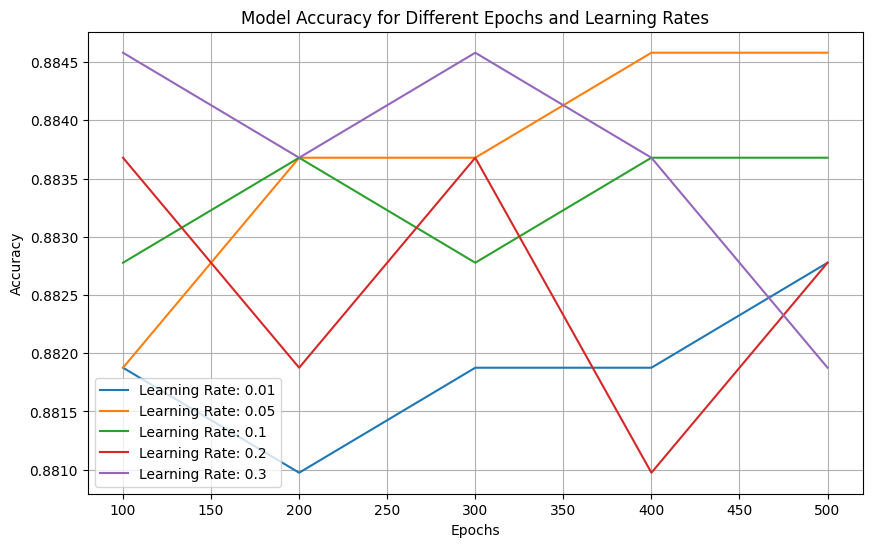

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import fasttext

# Example hyperparameters
epochs_values = [100, 200, 300, 400, 500]
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]

# Data preparation (replace this with your actual data loading and preprocessing)
X = df['Sentences']
y = df['Label']
train_texts, test_texts, train_labels, test_labels = train_test_split(
    X, y, test_size=0.1, random_state=42
)

train_labels = train_labels.fillna('').astype(str)
train_texts = train_texts.fillna('').astype(str)

train_texts = ['__label__' + label + ' ' + text for label, text in zip(train_labels, train_texts)]
test_texts = ['__label__' + label + ' ' + text for label, text in zip(test_labels, test_texts)]

# Store accuracy values for different hyperparameters
accuracy_values = []

for epochs in epochs_values:
    for lr in learning_rates:
        # Train the model
        model = fasttext.train_supervised(
            input="CandogramData/train_fasttext.txt",
            epoch=epochs,
            lr=lr,
            wordNgrams=5,
            dim=200
        )

        # Test the model
        test_results = model.test("CandogramData/test_fasttext.txt")
        accuracy = test_results[1]
        accuracy_values.append((epochs, lr, accuracy))

# Unpack the results for plotting
epochs_list, lr_list, accuracy_list = zip(*accuracy_values)

# Plotting
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    accuracy_lr = [acc for ep, lr_val, acc in accuracy_values if lr_val == lr]
    plt.plot(epochs_values, accuracy_lr, label=f'Learning Rate: {lr}')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Different Epochs and Learning Rates')
plt.legend()
plt.grid(True)
plt.show()